### Branch-and-Price Framework

- Features:
    - Python + Gurobi/etc.
    - Self-defined PricingProblem/BranchingRules
    - A demo of GraphColoringProblem
    
- TODOs: 
    - Add Cut
    - Parallel
    - Node Visiting Priority

In [20]:
import numpy as np
import random
from gurobipy import *
import queue
import time
from threading import Lock
from threading import Thread

In [2]:
from abc import ABC, abstractmethod
from timeit import default_timer as timer

In [3]:
# debug utils
from importlib import reload
import logging
import inspect


def log(message, logger=logging.error):
    func = inspect.currentframe().f_back.f_code
    logging.debug("{}\t[{}, {}, {}]".format(message,
        func.co_name, 
        func.co_filename, 
        func.co_firstlineno))
    
    
def _printLP(m):
    m.write('tmp.lp')
    f = open('tmp.lp', 'r')
    for l in f.readlines():
        print(l)
    print('====================')
    

def isInt(num):
    return (float(num)).is_integer()


In [4]:
# display flags
DEBUG = True
OUTPUT_LP = True
GRB_OUTPUT = False

reload(logging)
logging.basicConfig(level=logging.DEBUG if DEBUG else logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%I:%M:%S')
printGRBLP = lambda m: _printLP(m) if OUTPUT_LP else False

In [5]:
MAX_IT = 100000
MAX = 1e6
EPS = 1e-5

In [112]:
# constants
class pybnp:
    REAL = 0
    BINARY = 1
    INTEGER = 2
    INFINITY = 3
        

# abstract model
# min obj
# s.t. Ax <= b; x >= 0
class AbstractModel(ABC):
    @abstractmethod
    def __init__(self, name):
        self.name = name
        pass
    
    @abstractmethod
    def addRHS(self, bs):
        pass
    
    @abstractmethod
    def addVar(self, vtype, name, ub, obj, col):
        pass
    
    @abstractmethod
    def addConstrsByVarId(self, lhCoes, lhVarIds, rhs, name):
         pass
        
    @abstractmethod
    def addConstrsByVarName(self, lhCoes, lhVarNames, rhs, name):
         pass
        
    @abstractmethod
    def removeConstrById(self, constrId):
        pass
    
    @abstractmethod
    def removeConstrsByName(self, constrName):
        pass
    
    @abstractmethod
    def removeVarById(self, varId):
        pass

    @abstractmethod
    def removeVarByName(self, varName):
        pass

    @abstractmethod
    def optimize(self):
        pass
    
    @abstractmethod
    def updateObjById(self, objCoes, varIds):
        pass
    
    @abstractmethod
    def updateObjByName(self, objCoes, varNames):
        pass
    
    @abstractmethod
    def getIsOptimal(self):
        pass
        
    @abstractmethod
    def getObjVal(self):
        pass
    
    @abstractmethod
    def getSol(self):
        pass
    
    @abstractmethod
    def getSolVals(self):
        pass

    @abstractmethod
    def getDualPis(self):
        pass
    
    @abstractmethod
    def printProgram(self):
        pass

    @abstractmethod
    def printSolution(self):
        pass
    
    @abstractmethod
    def getBs(self):
        pass
    
    
    @abstractmethod
    def getNonZeroColsSol(self):
        pass

    
    
# GurobiSolver
class GurobiModel(AbstractModel):
    def __init__(self, name='untitled_model'):
        self.model = Model(name)
        self.model.setParam("OutputFlag", GRB_OUTPUT)
        self.model.setAttr('ModelSense', GRB.MINIMIZE)
        self.vars = []
        self.constrs = {}
        self.bs = []
        self.name = name
    
    
    def addRHS(self, bs):
        self.bs = bs
        self.model.addConstrs((0 <= b for b in bs))
        self.model.update()
        for b, c in zip(bs, self.model.getConstrs()):
            c.setAttr('RHS', b)
        self.model.update()

    
    # col= ([RowIds], [Coes])
    def addVar(self, name, vtype=pybnp.REAL, ub=pybnp.INFINITY, obj=0, col=None):
        newCols = None
        if col != None:
            constrs = self.model.getConstrs()
            newCols = Column(col[1], [constrs[cid] for cid in col[0]])
        ub = GRB.INFINITY if ub == pybnp.INFINITY else ub
        GRBvtypeMap = dict({pybnp.INTEGER: GRB.INTEGER, pybnp.REAL: GRB.CONTINUOUS, pybnp.BINARY: GRB.BINARY})
        v = self.model.addVar(obj=obj, vtype=GRBvtypeMap[vtype], name=name, ub=ub, column=newCols)
        self.vars.append(v)
    
    
    def addConstrsByVarId(self, lhCoes, lhVarIds, rhs, name):
        #print('add constr', name)
        newConstrs = self.model.addConstrs(( quicksum( lhc * self.vars[lhVid] for lhc, lhVid in zip(lhCoes[i], lhVarIds[i])) <= rhs[i] 
                               for i in range(len(rhs))), name=name)
        self.constrs[name] = newConstrs
        self.model.update()
        
        
    def addConstrsByVarName(self, lhCoes, lhVarNames, rhs, name):
        raise NotImplemented('TBD') 
        
        
    def removeConstrById(self, constrId):
        constrs = self.model.getConstrs()
        self.model.remove(constrs[constrId])
        self.model.update()
    
    
    def removeConstrsByName(self, constrName):
        constrs = self.constrs[constrName]
        self.model.remove(constrs)
        self.model.update()
    
    
    def removeVarById(self, varId):
        vs = self.model.getVars()
        self.model.remove(vs[varId])


    def removeVarByName(self, varName):
        raise NotImplemented('TBD') 


    def optimize(self):
        self.model.optimize()
        return self.model.Runtime
        
    
    def updateObjById(self, objCoes, varIds):
        self.model.setObjective( quicksum( c * self.vars[i] for c,i in zip(objCoes, varIds) ))
        
        
    def updateObjByName(self, objCoes, varNames):
        raise NotImplemented('TBD') 
    

    def getIsOptimal(self):
        return self.model.status == GRB.OPTIMAL
        
        
    def getObjVal(self):
        return self.model.objVal
    

    def getSol(self):
        return self.model.getVars()
    
    
    def getSolVals(self):
        return [v.x for v in self.model.getVars()]


    def getDualPis(self):
        return self.model.getAttr('Pi', self.model.getConstrs())
        
    
    def printProgram(self):
        printGRBLP(self.model)

        
    def printSolution(self):
        if not OUTPUT_LP:
            return 
        if self.getIsOptimal():
            for v in self.getSol():
                print('{} = {}'.format(v.varName, v.x))
        else:
            print('not optimal')
    
    
    def getBs(self):
        return self.bs
    
    
    def getNonZeroColsSol(self):
        m = self.model
        cs = m.getConstrs()
        c2i = dict(zip(cs, range(len(cs))))
        cols = []
        sol = []
        for v in m.getVars():
            if v.x == 0:
                continue
            rawCol = m.getCol(v)
            col = ([], [])
            for i in range(rawCol.size()):
                col[0].append(c2i[m.getCol(v).getConstr(i)])
                col[1].append(m.getCol(v).getCoeff(i))
            cols.append(col)
            sol.append(v.x)
        return (cols, sol)

        


class abstractBnP(ABC):
    def __init__(self, name, data, modelClass, pq=True):
        self.name = name
        self.data = data
        self.modelClass = modelClass
        
        self.muteColGened = False
        self.muteBranchBegin = False
        self.muteBranchSolved = False
        self.muteNewBranchAdded = False
        self.runTime = 0
        self.MuteOutputFlags()
        self.pq = pq
        
        
    @abstractmethod
    def ProvideMasterRHS(self):
        pass
    
    
    @abstractmethod
    def BuildPricingProblem(self):
        pass
    
    
    @abstractmethod
    def SolvePricingProblem(self):
        pass
    
    
    @abstractmethod
    def GetNewColFromPrcing(self):
        pass
    
    
    @abstractmethod
    def UpdatePricingProblem(self, dualPrices):
        pass
    
    
    @abstractmethod
    def onBranchingPerformed(self, branchDecision):
        pass
    
    
    @abstractmethod
    def onBranchingReverted(self, branchDecision):
        pass
    
    
    @abstractmethod
    def CreateBranches(self, cols, sol):
        pass
    
    
    #([RowIds], [Coes])
    @abstractmethod
    def EvaluateCol(self, col):
        pass
    
    
    #([RowIds], [Coes])
    @abstractmethod
    def NameCol(self, col):
        pass
        
    
    @abstractmethod
    def UBCol(self, col):
        pass
    
    
    @abstractmethod
    def CheckIntegralSolution(self, cols, sol):
        pass
    
    
    @abstractmethod
    def dispPricing(self):
        pass
    
    
    @abstractmethod
    def dispASolution(self, cols, sol):
        pass
    
    
    @abstractmethod
    def MuteOutputFlags(self):
        pass

    
    @abstractmethod
    def UniqueIDofBranchDecision(self, branchDecision):
        pass
    
    
    def dispMasterSolution(self):
        cols, sol = self.master.getNonZeroColsSol()
        self.dispASolution(cols, sol)
        
    
    def logColGened(self):
        if self.muteColGened:
            return
        #self.master.printProgram()
        print("pis: ", self.master.getDualPis())
        #self.master.printSolution()
        if self.master.getIsOptimal():  
            col = self.GetNewColFromPrcing()
            if col:
                print('new col: ', col)
            else:
                print('no new col')
        else:
            print('bad pricing')
            #self.pricing.printProgram()
            #self.pricing.printSolution()
    
    
    def logBranchBegin(self):
        if self.muteBranchBegin:
            return
        print('\n', ''.join(['-']*64), '\n')
        print('Current Branch: ', self.currentBranch, '\n\n')
        self.dispPricing()
        print('\n\n')
        
        
    def logBranchSolved(self):
        if self.muteBranchSolved:
            return
        print('\n\n\n')
        self.master.printProgram()
        print('\n\n')
        self.dispMasterSolution()
        print('current incumbent: ', self.incumbent)
        print('current bound: ', self.master.getObjVal(), '\n\n')
        
    
    def logNewBranchAdded(self, newBranch):
        if self.muteNewBranchAdded:
            return
        print('new branch: {}'.format(newBranch))

        
    def initMaster(self):
        self.master = self.modelClass(self.name+'[Master]')
        bs = self.ProvideMasterRHS()
        self.master.addRHS(bs)
        self.master.model.setParam(GRB.Param.Threads,  4)
        
        
    
    def addMasterCol(self, col, tag=''):
        self.master.addVar(vtype=pybnp.REAL, name=self.NameCol(col)+tag, 
                           ub=self.UBCol(col), obj=self.EvaluateCol(col), col=col)
        
        
    def addMasterArtificialCol(self, nodeName, rowId, rowCoe):
        col = ([rowId], [rowCoe])
        colName = '[{}at{}]'.format(nodeName, rowId)
        colObj = MAX
        colUb = self.UBCol(col)
        self.master.addVar(vtype=pybnp.REAL, name=colName, ub=colUb, obj=colObj, col=col)
    
    
    
    def _pricingWholeSol2Col(sol):
        return (list(range(len(sol))), [-s for s in sol])
    
    
    def genACol(self, i):
        self.master.model.params.presolve = 0
        te = self.master.optimize()
        
        self.runTime += te
        
        colAddedFlag = False
        
        if self.master.getIsOptimal():
            pis = self.master.getDualPis()
            self.UpdatePricingProblem(pis)
            te = self.SolvePricingProblem()
            
            self.runTime += te
            
            newCol = self.GetNewColFromPrcing()
            if newCol != False:
                self.addMasterCol(newCol, tag='[{}]'.format(i))
                colAddedFlag = True
        
        self.logColGened()
        
        return colAddedFlag
        
        
    def addMaterArtificialCols(self, nodeName=''):
        # add Artificial cols
        masterBs = self.master.getBs()
        for i in range(len(masterBs)):
            b = masterBs[i]
            rowId = i
            rowCoe = 1 if self.UBCol(None) ==pybnp.INFINITY else self.UBCol(None)
            rowCoe = b / rowCoe

            self.addMasterArtificialCol(nodeName, rowId, rowCoe)
    
    
    def isStillArtificial(self):
        # check if still has artificial
        sol = self.master.getSolVals()
        masterBs = self.master.getBs()
        return abs(sum(sol[:len(masterBs)])) > EPS
    
    
    def gcSolve(self, nodeName=''):
        self.addMaterArtificialCols(nodeName)
        
        # gen col and solve
        for it in range(MAX_IT):
            if not self.genACol(it):
                break
            
            if not self.master.getIsOptimal():
                log('master not good')
                break

        return not self.isStillArtificial()
    
    
    def processBranch(self, branchDecisions):
        A = branchDecisions
        B = self.currentBranch

#         print('two branches')
#         print(A)
#         print(B)
#         print('before', [c.ConstrName for c in self.pricing.model.getConstrs()])
        
        count = 0
        for i in range(min(len(A),len(B))):
            if B[i] != A[i]:
                break
            count += 1
        for i in range(1, 1+len(B) - count):
#             print('ready to remove', B[-i])
            bd = self.id2branchDecision[B[-i]]
            self.onBranchingReverted(bd)
        for i in range(count, len(A)):
#             print('ready to add', A[i])
            bd = self.id2branchDecision[A[i]]
            self.onBranchingPerformed(bd)
        self.currentBranch = A
#         print('after', [c.ConstrName for c in self.pricing.model.getConstrs()])
                
        
    def prepareGC(self):
        self.initMaster()
        self.BuildPricingProblem()
        
        
    def prepareBP(self):    
        self.Q = queue.PriorityQueue(maxsize=0)
        self.currentBranch = []
        
        self.incumbent = MAX
        self.intSol = []
        
        self.Q.put( (0, []) )
        
        self.runTime = 0
        self.nodeCount = 0
        
        self.branch2Node = {}
        self.nodeStatus = []
        self.nodeCreator = []
        self.nodeBound = []
        
        self.bd2id = {}
        self.id2branchDecision = {}
        self.bd2id[()] = 0
        self.id2branchDecision[0] = ()
        
        self._addNode([],[])
        
        
       
    
    def branchNamer(self, branch):
        return tuple(branch)
    
    
    def UniqueIDofBranchDecision(self, _branchDecision):
        branchDecision = tuple(_branchDecision)
        if not branchDecision in self.bd2id.keys():
            self.bd2id[branchDecision] = len(self.bd2id)
        return self.bd2id[branchDecision]
    
    
    def _addNode(self, _branch, _currentBranch):
        nid = len(self.branch2Node)
        branch = self.branchNamer(_branch)
        currentBranch = self.branchNamer(_currentBranch)
        self.branch2Node[branch] = nid
        self.nodeCreator.append( self.branch2Node[currentBranch] )
        self.nodeBound.append(MAX)
        self.nodeStatus.append(abstractBnP.NOT_SOLVED)
        
        
    def _updateNode(self, _branch, bound, status):
        branch = self.branchNamer(_branch)
        nid = self.branch2Node[branch]
        #print(nid, branch, _branch)
        self.nodeStatus[nid] = status
        self.nodeBound[nid] = bound
        
    
    def _updateGlobal(self):
        for nid in range(len(self.branch2Node)):
            if self.nodeBound[nid] <= self.incumbent and self.nodeStatus[nid] == abstractBnP.LOCAL_OPT:
                self.nodeStatus[nid] = abstractBnP.GLOBAL_OPT

        
    INFEASIBLE = 'inf'
    WORSE_BOUND = 'boundWorse' 
    WORSE_INT = 'intWorse'
    LOCAL_OPT = 'localOpt'
    GLOBAL_OPT = 'globalOpt'
    NOT_SOLVED = 'unsolved'
    FRAC = 'frac'
    
    
    # seq bnp
    def branchAndPrice(self):
        ta = timer()
        
        self.prepareGC()
        self.prepareBP()
        
        while not self.Q.empty():
            _, branchDecisions = self.Q.get()
            self.initMaster()
            self.processBranch(branchDecisions)
            
            self.logBranchBegin()
            
            isOptimial = self.gcSolve()
            
            self.nodeCount += 1
            
            self.logBranchSolved()
            
            # prune if infeasible
            if not isOptimial:
                self._updateNode(branchDecisions, MAX, abstractBnP.INFEASIBLE)
                continue
            
            bound = self.master.getObjVal()
            
            # prune if lower bound is larger than best interal obj
            if bound > self.incumbent:
                self._updateNode(branchDecisions, bound, abstractBnP.WORSE_BOUND)
                continue
            
            cols, sol = self.master.getNonZeroColsSol()    
            
            # integral
            if self.CheckIntegralSolution(cols, sol):
                if bound < self.incumbent:
                    self.incumbent = bound
                    self.intSol = [(cols, sol)]
                    self._updateNode(branchDecisions, bound, abstractBnP.LOCAL_OPT)
                elif bound == self.incumbent:
                    #print(branchDecisions, '==')
                    self._updateNode(branchDecisions, bound, abstractBnP.LOCAL_OPT)
                    self.intSol.append((cols, sol))
            else: # branch
                self._updateNode(branchDecisions, bound, abstractBnP.FRAC)
                
                branches = self.CreateBranches(cols, sol)
                for b in branches:
                    bdid = self.UniqueIDofBranchDecision(b)
                    self.id2branchDecision[bdid] = b
                    
                    newBranch = self.currentBranch + [bdid]
                    self.Q.put( (bound if self.pq else 0, newBranch) )
                    
                    self._addNode(newBranch, branchDecisions)
                    
                    self.logNewBranchAdded(newBranch)
                    
        self._updateGlobal()
        tb = timer()
        return tb - ta
    
    
    def drawBnPTree(self):
        import networkx as nx
        g = nx.DiGraph()
        for t in range(len(self.nodeCreator)):
            s = self.nodeCreator[t]
            g.add_edge(s,t)
        
        cm = {}  
        cm[abstractBnP.INFEASIBLE] = 'red'
        cm[abstractBnP.WORSE_BOUND] = 'purple'
        cm[abstractBnP.WORSE_INT] = 'yellow'
        cm[abstractBnP.LOCAL_OPT] = 'blue'
        cm[abstractBnP.GLOBAL_OPT] = 'green'
        cm[abstractBnP.FRAC] = 'orange'
        cm[abstractBnP.NOT_SOLVED] = 'gray'
    
        colorMap = ['black'] * len(g.nodes())
        #print(g.nodes(), self.nodeStatus)
        for n in g.nodes():
            colorMap[n] = cm[self.nodeStatus[n]]

        nx.draw(g, pos=nx.spring_layout(g), node_color = colorMap)
        
#         from networkx.drawing.nx_agraph import write_dot, graphviz_layout
#         write_dot(g,'test.dot')

#         pos =graphviz_layout(g, prog='dot')
#         nx.draw(g, pos, with_labels=False, arrows=True,  node_color = colorMap)
        

In [113]:
class GCPBnP(abstractBnP):
    
    def dispPricing(self):
        self.pricing.printProgram()
        
        
    def dispASolution(self, cols, sol):
        print('solution: ')
        for col, s in zip(cols, sol):
            print(self.col2Nodes(col), s)
        
        
    def MuteOutputFlags(self):
        pass
#         self.muteColGened = True
#         self.muteBranchBegin = True
#         self.muteBranchSolved = True
#         self.muteNewBranchAdded = True
    
    
    # new method
    def decisionNamer(self, branchDecision):
        return str(branchDecision)
    
    
    def onBranchingPerformed(self, branchDecision):
        a, b, isSame, tag = branchDecision
        branchName = self.decisionNamer(branchDecision)
        cs = []
        
        if not isSame:
            self.pricing.addConstrsByVarId(lhCoes=[[1, 1]], lhVarIds=[[a,b]], rhs=[1], name=branchName)            
        else:
            self.pricing.addConstrsByVarId(lhCoes=[[1, -1], [-1, 1]], lhVarIds=[[a,b], [a,b]],
                                           rhs=[0, 0], name=branchName)
        
    
    def onBranchingReverted(self, branchDecision):
        decisionName = self.decisionNamer(branchDecision)
#         print(decisionName)
#         print(self.pricing.constrs.keys())
        self.pricing.removeConstrsByName(decisionName)
    
    
    def CreateBranches(self, cols, sol):
        N, edges = data
        v, u = -1, -1
        tag = random.randint(1,1e5)
        for col1, s1, i in zip(cols, sol, range(len(sol))):
            for col2, s2, j in zip(cols, sol, range(len(sol))):
                nodeSet1 = self.col2Nodes(col1)
                nodeSet2 = self.col2Nodes(col2)
                if i != j and not isInt(s1) and not isInt(s2):
                    for x in range(N):
                        for y in range(N):
                            if x == y:
                                continue
                            if x in nodeSet1 and x in nodeSet2 and y in nodeSet1 and y not in nodeSet2:
                                v = min(x, y)
                                u = max(x, y)
                                return [(v, u, True, tag), (v, u, False, tag)]
        return [(v, u, True, tag), (v, u, False, tag)]

    
    def CheckIntegralSolution(self, cols, sol):
        for s in sol:
            if not isInt(s):
                return False
        return True
    
    
    def ProvideMasterRHS(self):
        N, edges = self.data
        return [-1] * N
    
    
    def BuildPricingProblem(self):
        N, edges = self.data
        pricing = self.modelClass(self.name + '_Pricing')
        vs = [pricing.addVar(name='v{}'.format(i), ub=1, obj=0, vtype=pybnp.BINARY) for i in range(N)]
        for s,t in edges:
            pricing.addConstrsByVarId( [[1,1]], [[s,t]], [1], 'v_{}_{}'.format(s,t) )
        self.pricing = pricing
    
    
    def SolvePricingProblem(self):
        return self.pricing.optimize()
    
    
    def GetNewColFromPrcing(self):
        newCol = abstractBnP._pricingWholeSol2Col( self.pricing.getSolVals() )
        if self.EvaluateCol(newCol) + self.pricing.getObjVal() <= -EPS:
            return newCol
        else:
            return False
        
    
    def UpdatePricingProblem(self, dualPrices):
        self.pricing.updateObjById(dualPrices, list(range(len(dualPrices))))
      
    
    #([RowIds], [Coes])
    def EvaluateCol(self, col):
        return 1
    
    
    #([RowIds], [Coes])
    def NameCol(self, col):
        return 'g' + ''.join(['{}'.format(node) for node in self.col2Nodes(col)])
        
        
    def UBCol(self, col):
        return 1
    
    
    # new methods
    def col2Nodes(self, col):
        return [rid for rid, rCoe in zip(col[0], col[1]) if rCoe != 0]
    
    
    def plot(self,colored=False):
        cols, sol = self.intSol[0]
        self._plot(cols, sol, colored)
            
    
    def _plot(self, cols, sol, colored=False):
        import networkx as nx
        N, edges = self.data
        g = nx.Graph()
        g.add_edges_from(edges)
        node2id = dict(zip(g.nodes(), range(len(g.nodes()))))
        if not colored:
            nx.draw(g, pos=nx.spring_layout(g), with_labels = True)
        else:
            colorMap = list(range(N))
            colors = ['blue', 'red', 'yellow', 'green', 'purple', 'orange', 'black', 'gray', 'gold', 'roralblue', 'coral', 'pink' ]
            count = 0
            for col in cols:
                for node in self.col2Nodes(col):
                    colorMap[node2id[node]] = colors[count]
                count += 1
            nx.draw(g, pos=nx.spring_layout(g), with_labels = True, node_color = colorMap)
    

In [114]:
# demo
N = 5
edges = [(0, 1), (1, 4), (2, 3), (0, 3), (2, 4)]
data = (N, edges)


/Users/SunJc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/SunJc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


(0.014871817000084775, 0.006102085113525391, 3, None)

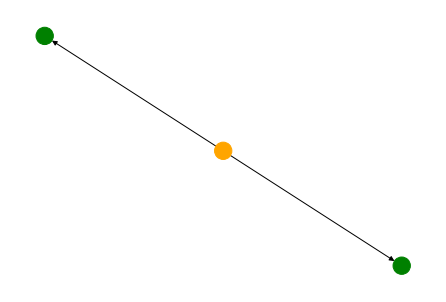

In [115]:
bnp = GCPBnP('demo', data, GurobiModel)
OUTPUT_LP = False
bnp.muteColGened = True
bnp.muteBranchBegin = True
bnp.muteBranchSolved = True
bnp.muteNewBranchAdded = True
bnp.branchAndPrice(), bnp.runTime, bnp.nodeCount, bnp.drawBnPTree()

3.0
solution: 
[0, 2] 1.0
[3, 4] 1.0
[1, 3] 1.0
solution: 
[1, 3] 1.0
[0, 4] 1.0
[1, 2] 1.0


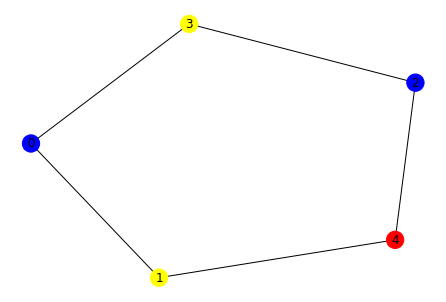

In [116]:
bnp.plot(colored=True)
print(bnp.incumbent)
for cols, sol in bnp.intSol:
    bnp.dispASolution(cols, sol)

In [117]:
# par
class abstractParBnP(ABC):
    def __init__(self, name, data, modelClass, par=1):
        self.name = name
        self.data = data
        self.modelClass = modelClass
        
        self.par = par
        
        self.muteColGened = False
        self.muteBranchBegin = False
        self.muteBranchSolved = False
        self.muteNewBranchAdded = False
        self.runTime = 0
        self.MuteOutputFlags()
        
        
        
        
    @abstractmethod
    def ProvideMasterRHS(self):
        pass
    
    
    @abstractmethod
    def PricingProblemBuilder(self, tag):
        pass # return pricing
    
    
    @abstractmethod
    def PricingProblemSolver(self, pricingProblem):
        pass
    
    
    @abstractmethod
    def NewColFromPrcingGetter(self, pricingProblem):
        pass
    
    
    @abstractmethod
    def PricingProblemUpdater(self, dualPrices, pricingProblem):
        pass
    
    
    @abstractmethod
    def onBranchingPerformed(self, branchDecision, masterProblem, pricingProblem):
        pass
    
    
    @abstractmethod
    def onBranchingReverted(self, branchDecision, masterProblem, pricingProblem):
        pass
    
    
    @abstractmethod
    def CreateBranches(self, cols, sol):
        pass
    
    
    #([RowIds], [Coes])
    @abstractmethod
    def EvaluateCol(self, col):
        pass
    
    
    #([RowIds], [Coes])
    @abstractmethod
    def NameCol(self, col):
        pass
        
    
    @abstractmethod
    def UBCol(self, col):
        pass
    
    
    @abstractmethod
    def CheckIntegralSolution(self, cols, sol):
        pass
    
    
    @abstractmethod
    def dispPricing(self, pricingProblem):
        pass
    
    
    @abstractmethod
    def dispASolution(self, cols, sol):
        pass
    
    
    @abstractmethod
    def MuteOutputFlags(self):
        pass

    
    @abstractmethod
    def UniqueIDofBranchDecision(self, branchDecision):
        pass
    
    
    def dispMasterSolution(self, masterProblem):
        cols, sol = masterProblem.getNonZeroColsSol()
        self.dispASolution(cols, sol)
        
    
    def logColGened(self, masterProblem, pricingProblem):
        if self.muteColGened:
            return
        #self.master.printProgram()
        print("pis: ", masterProblem.getDualPis())
        #self.master.printSolution()
        if masterProblem.getIsOptimal():  
            col = self.NewColFromPrcingGetter(pricingProblem)
            if col:
                print('[{}] new col: '.format(masterProblem.name), col)
            else:
                print('[{}] no new col'.format(masterProblem.name))
        else:
            print('bad pricing')
            #self.pricing.printProgram()
            #self.pricing.printSolution()
    
    
    def logBranchBegin(self, currentBranch, masterProblem, pricingProblem):
        if self.muteBranchBegin:
            return
        print('\n', ''.join(['-']*64), '\n')
        print('Current Branch: ', currentBranch, '\n\n')
        self.dispPricing(pricingProblem)
        print('\n\n')
        
        
    def logBranchSolved(self, currentBranch, masterProblem, pricingProblem):
        if self.muteBranchSolved:
            return
        print('\n\n\n')
        masterProblem.printProgram()
        print('\n\n')
        self.dispMasterSolution(masterProblem)
        print('current incumbent: ', self.incumbent)
        print('current bound: ', masterProblem.getObjVal(), '\n\n')
        
    
    def logNewBranchAdded(self, newBranch, masterProblem, pricingProblem):
        if self.muteNewBranchAdded:
            return
        print('new branch: {}'.format(newBranch))

        
    def MasterBuilder(self, tag):
        master = self.modelClass(self.name+'[Master]'+tag)
        bs = self.ProvideMasterRHS()
        master.addRHS(bs)
        return master
        
    
    def MasterColAdder(self, masterProblem, col, tag=''):
        masterProblem.addVar(vtype=pybnp.REAL, name=self.NameCol(col)+tag, 
                           ub=self.UBCol(col), obj=self.EvaluateCol(col), col=col)
        
        
    def MasterArtificialColAdder(self, masterProblem, nodeName, rowId, rowCoe):
        col = ([rowId], [rowCoe])
        colName = '[{}at{}]'.format(nodeName, rowId)
        colObj = MAX
        colUb = self.UBCol(col)
        masterProblem.addVar(vtype=pybnp.REAL, name=colName, ub=colUb, obj=colObj, col=col)
    
    
    
    def _pricingWholeSol2Col(sol):
        return (list(range(len(sol))), [-s for s in sol])
    
    
    def AColGener(self, masterProblem, pricingProblem, i):
        #masterProblem.model.params.presolve = 0
        te = masterProblem.optimize()
        
        with self.lock:
            self.runTime += te
        
        colAddedFlag = False
        
        if masterProblem.getIsOptimal():
            pis = masterProblem.getDualPis()
            self.PricingProblemUpdater(pis, pricingProblem)
            te = self.PricingProblemSolver(pricingProblem)
            
            with self.lock:
                self.runTime += te
            
            newCol = self.NewColFromPrcingGetter(pricingProblem)
            if newCol != False:
                self.MasterColAdder(masterProblem, newCol, tag='[{}]'.format(i))
                colAddedFlag = True
        
        self.logColGened(masterProblem, pricingProblem)
        
        return colAddedFlag
        
        
    def MaterArtificialColsAdder(self, masterProblem, nodeName=''):
        # add Artificial cols
        masterBs = masterProblem.getBs()
        for i in range(len(masterBs)):
            b = masterBs[i]
            rowId = i
            rowCoe = 1 if self.UBCol(None) ==pybnp.INFINITY else self.UBCol(None)
            rowCoe = b / rowCoe

            self.MasterArtificialColAdder(masterProblem, nodeName, rowId, rowCoe)
    
    
    def isStillArtificial(self, masterProblem):
        # check if still has artificial
        sol = masterProblem.getSolVals()
        masterBs = masterProblem.getBs()
        return abs(sum(sol[:len(masterBs)])) > EPS
    
    
    def gcSolve(self, masterProblem, pricingProblem, nodeName=''):
        self.MaterArtificialColsAdder(masterProblem, nodeName)
        
        # gen col and solve
        for it in range(MAX_IT):
            if not self.AColGener(masterProblem, pricingProblem, it):
                break
            
            if not masterProblem.getIsOptimal():
                log('master not good')
                break

        return not self.isStillArtificial(masterProblem)
    
    
    def processBranch(self, currentBranch, branchDecisions, masterProblem, pricingProblem):
        A = branchDecisions
        B = currentBranch

#         print('two branches')
#         print(A)
#         print(B)
#         print('before', [c.ConstrName for c in self.pricing.model.getConstrs()])
        
        count = 0
        for i in range(min(len(A),len(B))):
            if B[i] != A[i]:
                break
            count += 1
        for i in range(1, 1+len(B) - count):
#             print('ready to remove', B[-i])
            bd = self.id2branchDecision[B[-i]]
            self.onBranchingReverted(bd, masterProblem, pricingProblem)
        for i in range(count, len(A)):
#             print('ready to add', A[i])
            bd = self.id2branchDecision[A[i]]
            self.onBranchingPerformed(bd, masterProblem, pricingProblem)
        return A
#         print('after', [c.ConstrName for c in self.pricing.model.getConstrs()])
                
            
        
    def prepareBP(self):    
        self.Q = queue.PriorityQueue()
        self.currentBranch = [[] for i in range(self.par)]
        
        self.incumbent = MAX
        self.intSol = []
        
        self.Q.put((0,[]))
        self.threadStatus = [abstractParBnP.IDLE for i in range(self.par)]
        
        self.runTime = 0
        self.nodeCount = 0
        
        self.branch2Node = {}
        self.nodeStatus = []
        self.nodeCreator = []
        self.nodeBound = []
        
        self.bd2id = {}
        self.id2branchDecision = {}
        self.bd2id[()] = 0
        self.id2branchDecision[0] = ()
        
        self.lock = Lock()
        self.qlock = Lock()
        
        self.mtlog = []
        
        self._addNode([],[])
        
        
        
        
       
    
    def branchNamer(self, branch):
        return tuple(branch)
    
    
    def UniqueIDofBranchDecision(self, _branchDecision):
        branchDecision = tuple(_branchDecision)
        if not branchDecision in self.bd2id.keys():
            with self.lock:
                self.bd2id[branchDecision] = len(self.bd2id)
        return self.bd2id[branchDecision]
    
    
    def _addNode(self, _branch, _currentBranch):
        with self.lock:
            nid = len(self.branch2Node)
            branch = self.branchNamer(_branch)
            #print(branch)
            currentBranch = self.branchNamer(_currentBranch)
            self.branch2Node[branch] = nid
            self.nodeCreator.append( self.branch2Node[currentBranch] )
            self.nodeBound.append(MAX)
            self.nodeStatus.append(abstractParBnP.NOT_SOLVED)
        
        
    def _updateNode(self, _branch, bound, status):
        with self.lock:
            branch = self.branchNamer(_branch)
            nid = self.branch2Node[branch]
            #print(nid, branch, _branch)
            self.nodeStatus[nid] = status
            self.nodeBound[nid] = bound
        
    
    def _updateGlobal(self):
        for nid in range(len(self.branch2Node)):
            if self.nodeBound[nid] <= self.incumbent and self.nodeStatus[nid] == abstractParBnP.LOCAL_OPT:
                self.nodeStatus[nid] = abstractParBnP.GLOBAL_OPT
        
        
    INFEASIBLE = 'inf'
    WORSE_BOUND = 'boundWorse' 
    WORSE_INT = 'intWorse'
    LOCAL_OPT = 'localOpt'
    GLOBAL_OPT = 'globalOpt'
    NOT_SOLVED = 'unsolved'
    FRAC = 'frac'
    BUSY = 1
    IDLE = 0
    SUICIDE = 'kill'
    
    
    def criticalQueueGet(self, threadId):
        res = None
        res = self.Q.get()
        with self.qlock:
            #print(threadId, 'get', res)
            self.mtlog.append((threadId, res))
            self.threadStatus[threadId] = abstractParBnP.BUSY
        return res
    
    
    def criticalRelease(self, threadId):
        res = False
        if self.Q.empty() and sum(self.threadStatus) == 1:
            return True
        with self.qlock:
            self.threadStatus[threadId] = abstractParBnP.IDLE
            #print(threadId, 'release')
            #print(self.Q.empty(), self.threadStatus, 'finish')
            res = self.Q.empty() and sum(self.threadStatus) == 0
        return res
        
    
    # main bnp
    def branchAndPriceMain(self):
        ta = timer()
        
        self.masters = []
        self.pricings = []
        for i in range(self.par):
            self.masters.append( self.MasterBuilder('<{}>'.format(i)) )
            self.pricings.append( self.PricingProblemBuilder('<{}>'.format(i)) )
        self.prepareBP()
        
        ths = [Thread(target=self.branchAndPriceDo, args=(i,)) for i in range(self.par)]
        #print(ths)
        for i in range(self.par):
            ths[i].start()
        for i in range(self.par):
            ths[i].join()
        
        tb = timer()
        
        self._updateGlobal()
        
        return tb - ta
    
    
    def branchAndPriceDo(self, i):
        masterProblem = self.masters[i]
        pricingProblem = self.pricings[i]
        
        while True:
            res = self.criticalQueueGet(i)
            if res == abstractParBnP.SUICIDE:
                # suicide
                return
            _, branchDecisions = res
            with self.lock:
                self.masters[i] = self.MasterBuilder('<{}>'.format(i)) 
                masterProblem = self.masters[i]

#             log("{}x".format(self.currentBranch, i))
            res = self.processBranch(self.currentBranch[i], branchDecisions, masterProblem, pricingProblem)
            with self.lock:
                self.currentBranch[i] = res


            self.logBranchBegin(branchDecisions, masterProblem, pricingProblem)

            isOptimial = self.gcSolve(masterProblem, pricingProblem)
            
            #print('lcocked', self.qlock.locked())
            #time.sleep(2)

            self.nodeCount += 1

            self.logBranchSolved(branchDecisions, masterProblem, pricingProblem)

            # prune if infeasible
            if not isOptimial:
                self._updateNode(branchDecisions, MAX, abstractParBnP.INFEASIBLE)
                if self.criticalRelease(i):
                    break

            bound = masterProblem.getObjVal()

            # prune if lower bound is larger than best interal obj
            if bound > self.incumbent:
                self._updateNode(branchDecisions, bound, abstractParBnP.WORSE_BOUND)
                if self.criticalRelease(i):
                    break

            cols, sol = masterProblem.getNonZeroColsSol()    

            # integral
            if self.CheckIntegralSolution(cols, sol):
                if bound < self.incumbent:
                    with self.lock:
                        self.incumbent = bound
                        self.intSol = [(cols, sol)]
                    self._updateNode(branchDecisions, bound, abstractParBnP.LOCAL_OPT)
                elif bound == self.incumbent:
                    #print(branchDecisions, '==')
                    self._updateNode(branchDecisions, bound, abstractParBnP.LOCAL_OPT)
                    with self.lock:
                        self.intSol.append((cols, sol))

                if self.criticalRelease(i):
                    break

            else: # branch
                self._updateNode(branchDecisions, bound, abstractParBnP.FRAC)

                branches = self.CreateBranches(cols, sol)
                for b in branches:
                    bdid = self.UniqueIDofBranchDecision(b)
                    with self.lock:
                        self.id2branchDecision[bdid] = b

                    newBranch = branchDecisions + [bdid]                    
                    self.Q.put( (bound, newBranch) )

                    self._addNode(newBranch, branchDecisions)

                    self.logNewBranchAdded(newBranch, masterProblem, pricingProblem)
                
                #time.sleep(2)
                if self.criticalRelease(i):
                    break
        
        for i in range(self.par-1):
            self.Q.put(abstractParBnP.SUICIDE)
        
    
        
    
    def drawBnPTree(self):
        import networkx as nx
        g = nx.DiGraph()
        for t in range(len(self.nodeCreator)):
            s = self.nodeCreator[t]
            g.add_edge(s,t)
        
        cm = {}  
        cm[abstractParBnP.INFEASIBLE] = 'red'
        cm[abstractParBnP.WORSE_BOUND] = 'purple'
        cm[abstractParBnP.WORSE_INT] = 'yellow'
        cm[abstractParBnP.LOCAL_OPT] = 'blue'
        cm[abstractParBnP.GLOBAL_OPT] = 'green'
        cm[abstractParBnP.FRAC] = 'orange'
        cm[abstractParBnP.NOT_SOLVED] = 'gray'
    
        colorMap = ['black'] * len(g.nodes())
        #print(g.nodes(), self.nodeStatus)
        for n in g.nodes():
            colorMap[n] = cm[self.nodeStatus[n]]

        nx.draw(g, pos=nx.spring_layout(g), with_labels = True, node_color = colorMap)
        
#         from networkx.drawing.nx_agraph import write_dot, graphviz_layout
#         write_dot(g,'test.dot')

#         pos =graphviz_layout(g, prog='dot')
#         nx.draw(g, pos, with_labels=False, arrows=True,  node_color = colorMap)
        

In [118]:
# par imp
class GCPParBnP(abstractParBnP):
    
    def dispPricing(self, pricingProblem):
        pricingProblem.printProgram()
        
        
    def dispASolution(self, cols, sol):
        print('solution: ')
        for col, s in zip(cols, sol):
            print(self.col2Nodes(col), s)
        
        
    def MuteOutputFlags(self):
        pass
#         self.muteColGened = True
#         self.muteBranchBegin = True
#         self.muteBranchSolved = True
#         self.muteNewBranchAdded = True
    
    
    # new method
    def decisionNamer(self, branchDecision):
        return str(branchDecision)
    
    
    def onBranchingPerformed(self, branchDecision, masterProblem, pricingProblem):
        a, b, isSame, tag = branchDecision
        branchName = self.decisionNamer(branchDecision)
        cs = []
        
        if not isSame:
            pricingProblem.addConstrsByVarId(lhCoes=[[1, 1]], lhVarIds=[[a,b]], rhs=[1], name=branchName)            
        else:
            pricingProblem.addConstrsByVarId(lhCoes=[[1, -1], [-1, 1]], lhVarIds=[[a,b], [a,b]],
                                           rhs=[0, 0], name=branchName)
        
    
    def onBranchingReverted(self, branchDecision, masterProblem, pricingProblem):
        decisionName = self.decisionNamer(branchDecision)
#         print(decisionName)
#         print(self.pricing.constrs.keys())
        pricingProblem.removeConstrsByName(decisionName)
    
    
    def CreateBranches(self, cols, sol):
        N, edges = data
        v, u = -1, -1
        tag = random.randint(1,1e5)
        for col1, s1, i in zip(cols, sol, range(len(sol))):
            for col2, s2, j in zip(cols, sol, range(len(sol))):
                nodeSet1 = self.col2Nodes(col1)
                nodeSet2 = self.col2Nodes(col2)
                if i != j and not isInt(s1) and not isInt(s2):
                    for x in range(N):
                        for y in range(N):
                            if x == y:
                                continue
                            if x in nodeSet1 and x in nodeSet2 and y in nodeSet1 and y not in nodeSet2:
                                v = min(x, y)
                                u = max(x, y)
                                return [(v, u, True, tag), (v, u, False, tag)]
        return [(v, u, True, tag), (v, u, False, tag)]

    
    def CheckIntegralSolution(self, cols, sol):
        for s in sol:
            if not isInt(s):
                return False
        return True
    
    
    def ProvideMasterRHS(self):
        N, edges = self.data
        return [-1] * N
    
    
    def PricingProblemBuilder(self, tag):
        N, edges = self.data
        pricing = self.modelClass(self.name + '_Pricing'+tag)
        vs = [pricing.addVar(name='v{}'.format(i), ub=1, obj=0, vtype=pybnp.BINARY) for i in range(N)]
        for s,t in edges:
            pricing.addConstrsByVarId( [[1,1]], [[s,t]], [1], 'v_{}_{}'.format(s,t) )
        return pricing
    
    
    def PricingProblemSolver(self, pricingProblem):
        return pricingProblem.optimize()
    
    
    def NewColFromPrcingGetter(self, pricingProblem):
        newCol = abstractParBnP._pricingWholeSol2Col( pricingProblem.getSolVals() )
        if self.EvaluateCol(newCol) + pricingProblem.getObjVal() <= -EPS:
            return newCol
        else:
            return False
        
    
    def PricingProblemUpdater(self, dualPrices, pricingProblem):
        pricingProblem.updateObjById(dualPrices, list(range(len(dualPrices))))
      
    
    #([RowIds], [Coes])
    def EvaluateCol(self, col):
        return 1
    
    
    #([RowIds], [Coes])
    def NameCol(self, col):
        return 'g' + ''.join(['{}'.format(node) for node in self.col2Nodes(col)])
        
        
    def UBCol(self, col):
        return 1
    
    
    # new methods
    def col2Nodes(self, col):
        return [rid for rid, rCoe in zip(col[0], col[1]) if rCoe != 0]
    
    
    def plot(self,colored=False):
        cols, sol = self.intSol[0]
        self._plot(cols, sol, colored)
            
    
    def _plot(self, cols, sol, colored=False):
        import networkx as nx
        N, edges = self.data
        g = nx.Graph()
        g.add_edges_from(edges)
        node2id = dict(zip(g.nodes(), range(len(g.nodes()))))
        if not colored:
            nx.draw(g, pos=nx.spring_layout(g), with_labels = True)
        else:
            colorMap = list(range(N))
            colors = ['blue', 'red', 'yellow', 'green', 'purple', 'orange', 'black', 'gray', 'gold', 'roralblue', 'coral', 'pink' ]
            count = 0
            for col in cols:
                for node in self.col2Nodes(col):
                    colorMap[node2id[node]] = colors[count]
                count += 1
            nx.draw(g, pos=nx.spring_layout(g), with_labels = True, node_color = colorMap)
    
    

9.177772538 5.66511344909668 275
6.0
solution: 
[2, 8, 9, 11, 13] 1.0
[0, 6, 10, 15, 18] 1.0
[1, 4, 5, 16] 1.0
[3, 12, 17] 1.0
[14, 19] 1.0
[7, 8, 9] 1.0
solution: 
[2, 8, 9, 13, 18] 1.0
[1, 5, 6, 16, 17] 1.0
[11, 14, 19] 1.0
[0, 4, 7] 1.0
[1, 10, 15] 1.0
[3, 12] 1.0
solution: 
[2, 8, 9, 13, 18] 1.0
[0, 4, 7] 1.0
[14, 19] 1.0
[5, 11, 16, 17] 1.0
[1, 6, 10, 15] 1.0
[3, 6, 12] 1.0
solution: 
[1, 5, 6, 16, 17] 1.0
[2, 8, 9, 18] 1.0
[3, 4, 12, 13] 1.0
[11, 14, 19] 1.0
[1, 10, 15] 1.0
[0, 4, 7, 16] 1.0
solution: 
[11, 14, 19] 1.0
[8, 9, 10, 14] 1.0
[3, 6, 12, 17] 1.0
[1, 2, 4, 13] 1.0
[0, 4, 7, 16] 1.0
[5, 15, 18] 1.0
solution: 
[4, 8, 12, 13, 18] 1.0
[1, 5, 16, 17] 1.0
[9, 11, 14, 19] 1.0
[0, 6, 10, 15] 1.0
[2, 3, 4] 1.0
[7, 9] 1.0
solution: 
[1, 2, 4, 8, 13] 1.0
[0, 9, 10, 15, 18] 1.0
[14] 1.0
[3, 6, 12, 17] 1.0
[5, 11, 19] 1.0
[1, 7, 16] 1.0
solution: 
[3, 5, 6, 16, 17] 1.0
[4, 8, 12, 13, 18] 1.0
[9, 14, 19] 1.0
[0, 10, 15] 1.0
[1, 7, 8] 1.0
[2, 11] 1.0
solution: 
[2, 4, 8, 13, 18] 1.0
[

9.742749331999903 5.997005939483643 223
root bound as queue weight, enhance: ['5.798946218848581%', '5.534303179555291%', '-23.318385650224215%']


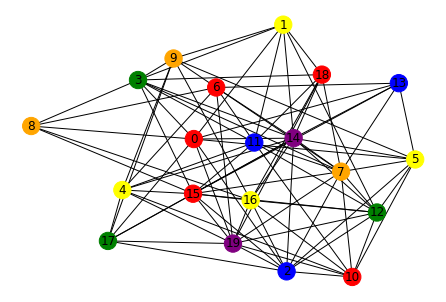

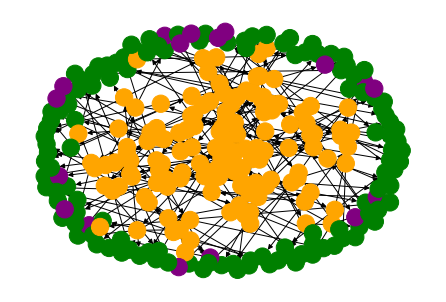

In [119]:
# test
N = 20
M = int(N*N * 0.3)
edges = set() 
x = None
data = (N, edges)

class tmpGCPBnP(GCPBnP):
    def MuteOutputFlags(self):
        self.muteColGened = True

for i in range(1000):
    edges = set() 
    nodes = set()
    for i in range(M):
        a = random.randint(0, N-1)
        b = random.randint(0, N-1)
        if a == b:
            continue
        nodes.add(a)
        nodes.add(b)
        edges.add((min(a, b), max(a, b)))
    
    for n in set(range(N)) - nodes:
        edges.add((0, n))
    edges = list(edges)
    data = (N, edges)


    x = tmpGCPBnP('demo', data, GurobiModel)
    
    x.prepareGC()
    x.gcSolve()

    cols, sol = x.master.getNonZeroColsSol()
    if not x.CheckIntegralSolution(cols, sol):
        bnp = GCPBnP('demo', data, GurobiModel)
        OUTPUT_LP = False
        bnp.muteColGened = True
        bnp.muteBranchBegin = True
        bnp.muteBranchSolved = True
        bnp.muteNewBranchAdded = True
        ts = bnp.branchAndPrice()
        if ts < 10:
            continue
        break
#x.plot()


# x.master.printSolution()
data = (N, edges)


bnp = GCPBnP('demo', data, GurobiModel)
OUTPUT_LP = False
bnp.muteColGened = True
bnp.muteBranchBegin = True
bnp.muteBranchSolved = True
bnp.muteNewBranchAdded = True
ts = bnp.branchAndPrice()

print(ts, bnp.runTime, bnp.nodeCount)
print(bnp.incumbent)
for cols, sol in bnp.intSol:
    bnp.dispASolution(cols, sol)


import matplotlib.pyplot as plt 
# print(edges)
# bnp.plot(colored=False)
# plt.figure()
bnp.plot(colored=True)
plt.figure()
bnp.drawBnPTree()


base_bnp = GCPBnP('demo', data, GurobiModel, pq=False)
OUTPUT_LP = False
base_bnp.muteColGened = True
base_bnp.muteBranchBegin = True
base_bnp.muteBranchSolved = True
base_bnp.muteNewBranchAdded = True
base_ts = base_bnp.branchAndPrice()

print(base_ts, base_bnp.runTime, base_bnp.nodeCount)
print('root bound as queue weight, enhance:', ['{}%'.format((b-a)/b*100) for a,b in zip([ts, bnp.runTime, bnp.nodeCount], [base_ts, base_bnp.runTime, base_bnp.nodeCount])])



6.0
solution: 
[2, 8, 9, 11, 13] 1.0
[0, 6, 10, 15, 18] 1.0
[1, 4, 5, 16] 1.0
[3, 12, 17] 1.0
[14, 19] 1.0
[7, 8, 9] 1.0
solution: 
[2, 8, 9, 13, 18] 1.0
[1, 5, 6, 16, 17] 1.0
[11, 14, 19] 1.0
[0, 4, 7] 1.0
[1, 10, 15] 1.0
[3, 12] 1.0
solution: 
[2, 8, 9, 13, 18] 1.0
[0, 4, 7] 1.0
[14, 19] 1.0
[5, 11, 16, 17] 1.0
[1, 6, 10, 15] 1.0
[3, 6, 12] 1.0
solution: 
[1, 5, 6, 16, 17] 1.0
[2, 8, 9, 18] 1.0
[3, 4, 12, 13] 1.0
[11, 14, 19] 1.0
[1, 10, 15] 1.0
[0, 4, 7, 16] 1.0
solution: 
[11, 14, 19] 1.0
[8, 9, 10, 14] 1.0
[3, 6, 12, 17] 1.0
[1, 2, 4, 13] 1.0
[0, 4, 7, 16] 1.0
[5, 15, 18] 1.0
solution: 
[4, 8, 12, 13, 18] 1.0
[1, 5, 16, 17] 1.0
[9, 11, 14, 19] 1.0
[0, 6, 10, 15] 1.0
[2, 3, 4] 1.0
[7, 9] 1.0
solution: 
[1, 2, 4, 8, 13] 1.0
[0, 9, 10, 15, 18] 1.0
[14] 1.0
[3, 6, 12, 17] 1.0
[5, 11, 19] 1.0
[1, 7, 16] 1.0
solution: 
[3, 5, 6, 16, 17] 1.0
[4, 8, 12, 13, 18] 1.0
[9, 14, 19] 1.0
[0, 10, 15] 1.0
[1, 7, 8] 1.0
[2, 11] 1.0
solution: 
[2, 4, 8, 13, 18] 1.0
[9, 11, 14, 19] 1.0
[3, 5, 16, 17]

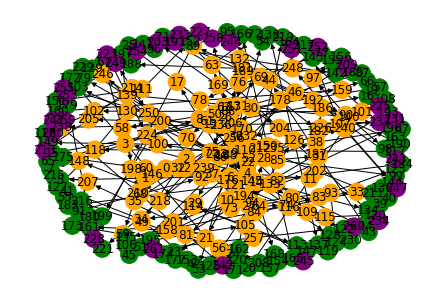

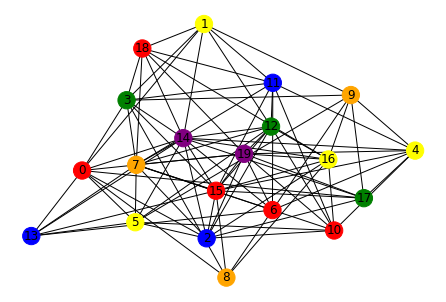

In [123]:


p_bnp = GCPParBnP('demo', data, GurobiModel, par=4)
OUTPUT_LP = False
p_bnp.muteColGened = True
p_bnp.muteBranchBegin = True
p_bnp.muteBranchSolved = True
p_bnp.muteNewBranchAdded = True

ts = p_bnp.branchAndPriceMain()

print(p_bnp.incumbent)
for cols, sol in bnp.intSol:
    p_bnp.dispASolution(cols, sol)
    
print(ts, p_bnp.runTime, p_bnp.nodeCount)
p_bnp.drawBnPTree()
plt.figure()
p_bnp.plot(colored=True)

In [121]:
base_bnp = GCPBnP('demo', data, GurobiModel, pq=False)
OUTPUT_LP = False
base_bnp.muteColGened = True
base_bnp.muteBranchBegin = True
base_bnp.muteBranchSolved = True
base_bnp.muteNewBranchAdded = True
base_ts = base_bnp.branchAndPrice()

print(base_ts, base_bnp.runTime, base_bnp.nodeCount)
print('root bound as queue weight, enhance:', ['{}%'.format((b-a)/b*100) for a,b in zip([ts, bnp.runTime, bnp.nodeCount], [base_ts, base_bnp.runTime, base_bnp.nodeCount])])


8.558046521000051 5.259777069091797 223
root bound as queue weight, enhance: ['-104.27376510635409%', '-7.706341441479991%', '-23.318385650224215%']
